# HW3 PIPELINE
## Building off HW2

In [29]:
## =======================================================
## IMPORTING
## =======================================================
import os
def get_data_from_files(path):
    directory = os.listdir(path)
    results = []
    for file in directory:
        f=open(path+file)
        results.append(f.read())
        f.close()
    return results

## =======================================================
## TOKENIZING
## =======================================================
from nltk.tokenize import word_tokenize, sent_tokenize
def get_tokens(sentence):
    tokens = word_tokenize(sentence)
    clean_tokens = [word.lower() for word in tokens if word.isalpha()]
    return clean_tokens

def get_sentence_tokens(review):
    return sent_tokenize(review)

## =======================================================
## REMOVING STOPWORDS
## =======================================================
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
def remove_stopwords(sentence):
    filtered_text = []
    for word in sentence:
        if word not in stop_words:
            filtered_text.append(word)
    return filtered_text

## =======================================================
## FREQUENCY DISTRIBUTIONS
## =======================================================
from nltk.probability import FreqDist
def get_most_common(tokens):
    fdist = FreqDist(tokens)
    return fdist.most_common(12)

def get_most_common(tokens):
    fdist = FreqDist(tokens)
    return fdist.most_common(12)

def get_fdist(tokens):
    return (FreqDist(tokens))

## =======================================================
## SENTIMENT ANALYSIS
## =======================================================
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

def get_vader_score(review):
    return sid.polarity_scores(review)

def separate_vader_score(vader_score, key):
    return vader_score[key]

## =======================================================
## SUMMARIZER
## =======================================================
def get_weighted_freq_dist(review, freq_dist):
    max_freq = max(freq_dist.values())
    for word in freq_dist.keys():
        freq_dist[word] = (freq_dist[word]/max_freq)
    return freq_dist

def get_sentence_score(review, freq_dist):
    sentence_scores = {}
    for sent in review:
        for word in nltk.word_tokenize(sent.lower()):
            if word in freq_dist.keys():
                if len(sent.split(' ')) < 30:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = freq_dist[word]
                    else:
                        sentence_scores[sent] += freq_dist[word]
    return sentence_scores

def get_summary_sentences(sentence_scores):
    sorted_sentences = sorted(sentence_scores.items(), key=lambda kv: kv[1], reverse=True)
    return ''.join(sent[0] for sent in sorted_sentences[:5])

def get_freq_words(freq_dist):
    sorted_words = sorted(freq_dist.items(), key=lambda kv: kv[1], reverse=True)
    return ' '.join(word[0] for word in sorted_words[:50])

## =======================================================
## MACHINE LEARNING -- NAIVE BAYES
## =======================================================
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

# def get_NB(small_df, labels):
#     x_train, x_test, y_train, y_test = train_test_split(small_df.values, labels, test_size=0.3, random_state = 109)

#     gnb = GaussianNB()
#     gnb.fit(x_train, y_train)
#     y_pred = gnb.predict(x_test)
#     print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    
    
def get_NB(small_df, labels, classifier, title):
    seeds = [109, 210, 420, 19, 7]
    dfs = []
    overall = []
    print(title)
    for seed in seeds:
        x_train, x_test, y_train, y_test = train_test_split(small_df.values, 
                                                            labels, test_size=0.3, random_state = seed)
        gnb = classifier
        gnb.fit(x_train, y_train).score(x_train, y_train)
        y_pred = gnb.predict(x_test)
        accuracy =  metrics.accuracy_score(y_test, y_pred)
        report = metrics.classification_report(y_test, y_pred)
        print("Accuracy:", accuracy)
#         print(report)
        overall.append(accuracy)
        cm = confusion_matrix(y_test, y_pred)
        # confusion_matrix_graph(cm, accuracy, "NB Multinomial Tokenized")
        tn, fp, fn, tp = cm.ravel()
        df = pd.DataFrame({ 'labels': ['accuracy','true neg', 'false pos', 'false neg', 'true pos'], 
                           'nums': [accuracy, tn, fp, fn, tp] })
        dfs.append(df)
    print('AVERAGE ACCURACY:', sum(overall)/len(overall))
    return dfs


def display_NB_tables(dfs):
    for df in dfs:
        print(display(df))
        
## =======================================================
## PLOTS
## =======================================================        
import seaborn as sns
import matplotlib.pyplot as plt 
def bar_plot(df, title): 
    graph = sns.barplot(y = "count", x = "word", data = df, palette = "husl")
    plt.title(title)
    plt.xlabel("Word")
    plt.ylabel("Count")
    sns.set_context("talk")
    plt.xticks(rotation = 90)
    return plt

from nltk.tokenize import casual_tokenize
from collections import Counter


## =======================================================
## CLEANERS
## =======================================================   
import re, string
def diy_cleaner(review):
    try:
        both = review.split('\n')
        title = both[0]
        review = both[1]
        review = review.replace("'","")
    except:
        review = review.replace("'","")
    pattern = re.compile('[\W_]+')
    review = pattern.sub(' ', review)
    cleaned = title + ' ' + title + ' ' + review
    return cleaned.lower()

def pruner(review):
    clean_review = ' '.join([word for word in review.split() if len(word) > 3])
    return clean_review

sentim_analyzer = SentimentAnalyzer()
def get_nltk_negs(tokens):
    all_words_neg = sentim_analyzer.all_words([mark_negation(tokens)])
    return all_words_neg

def get_unigram_feats(neg_tokens):
    unigram_feats = sentim_analyzer.unigram_word_feats(neg_tokens)
    return unigram_feats
    
def get_bigram_feats(tokens):
    ngrams = zip(*[tokens[i:] for i in range(2)])
    return ["_".join(ngram) for ngram in ngrams]

## =======================================================
## HELPERS
## =======================================================  
def get_bow_from_column(df, column):
    all_column_data = ' '.join(df[column].tolist())
    all_column_fd = Counter(all_column_data.split())
    return all_column_fd

def get_common_words(num):
    most_common_neg = [word[0] for word in big_bow_n.most_common(num)]
    most_common_pos = [word[0] for word in big_bow_p.most_common(num)]
    in_both = np.intersect1d(most_common_neg, most_common_pos)
    neg_notpos = np.setdiff1d(most_common_neg, most_common_pos)
    pos_notneg = np.setdiff1d(most_common_pos, most_common_neg)
    return [len(in_both), len(neg_notpos), len(pos_notneg), len(in_both)/num, in_both, neg_notpos, pos_notneg]

def get_only_polarized(tokens, common_words):
    return [token for token in tokens if token not in common_words[4]] # 70

## =======================================================
## VISUALS
## =======================================================  
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt 
def create_word_cloud_with_mask(path_of_mask_image, dictionary, 
                                max_num_words, title):
        mask = np.array(Image.open(path_of_mask_image))
        word_cloud = WordCloud(background_color = "white", 
                               max_words = max_num_words, 
                               mask = mask, max_font_size = 125, 
                               random_state = 1006)
        word_cloud.generate_from_frequencies(dictionary)
        image_colors = ImageColorGenerator(mask)
        plt.figure(figsize = [8,8])
        plt.imshow(word_cloud.recolor(color_func = image_colors), interpolation = "bilinear")
        plt.title(title)
        sns.set_context("poster")
        plt.axis("off")
        return plt
    
import seaborn as sns
import matplotlib.pyplot as plt 
def bar_plot(df, title): 
    graph = sns.barplot(y = "count", x = "word", data = df, palette = "husl")
    plt.title(title)
    plt.xlabel("Word")
    plt.ylabel("Count")
    sns.set_context("talk")
    plt.xticks(rotation = 90)
    return plt

In [30]:
# neg = get_data_from_files('../NEG_JK/')
# pos = get_data_from_files('../POS_JK/')

# neg = get_data_from_files('../neg_cornell/')
# pos = get_data_from_files('../pos_cornell/')

neg = get_data_from_files('../neg_hw4/')
pos = get_data_from_files('../pos_hw4/')

# neg = get_data_from_files('../hw4_lie_false/')
# pos = get_data_from_files('../hw4_lie_true/')

# pos = get_data_from_files('../hw4_lie_false/')
# neg = get_data_from_files('../hw4_lie_true/')

import pandas as pd
import numpy as np
neg_df = pd.DataFrame(neg)
pos_df = pd.DataFrame(pos)
pos_df['PoN'] = 'P'
neg_df['PoN'] = 'N'
all_df = neg_df.append(pos_df)

all_df['tokens'] = all_df.apply(lambda x: get_tokens(x[0]), axis=1)
all_df['num_tokens'] = all_df.apply(lambda x: len(x['tokens']), axis=1)

all_df = all_df.drop(all_df[all_df.num_tokens < 1].index)

all_df['sentences'] = all_df.apply(lambda x: get_sentence_tokens(x[0]), axis=1)
all_df['num_sentences'] = all_df.apply(lambda x: len(x['sentences']), axis=1)

all_df['no_sw'] = all_df.apply(lambda x: remove_stopwords(x['tokens']),axis=1)
all_df['num_no_sw'] = all_df.apply(lambda x: len(x['no_sw']),axis=1)

all_df['topwords_unfil'] = all_df.apply(lambda x: get_most_common(x['tokens']),axis=1)
all_df['topwords_fil'] = all_df.apply(lambda x: get_most_common(x['no_sw']),axis=1)

all_df['freq_dist'] = all_df.apply(lambda x: get_fdist(x['no_sw']),axis=1)
all_df['freq_dist_unfil'] = all_df.apply(lambda x: get_fdist(x['tokens']),axis=1)

all_df['vader_all'] = all_df.apply(lambda x: get_vader_score(x[0]),axis=1)
all_df['v_compound'] = all_df.apply(lambda x: separate_vader_score(x['vader_all'], 'compound'),axis=1)
all_df['v_neg'] = all_df.apply(lambda x: separate_vader_score(x['vader_all'], 'neg'),axis=1)
all_df['v_neu'] = all_df.apply(lambda x: separate_vader_score(x['vader_all'], 'neu'),axis=1)
all_df['v_pos'] = all_df.apply(lambda x: separate_vader_score(x['vader_all'], 'pos'),axis=1)

all_df['weighted_freq_dist'] = all_df.apply(lambda x: get_weighted_freq_dist(x['sentences'], x['freq_dist']),axis=1)
all_df['sentence_scores'] = all_df.apply(lambda x: get_sentence_score(x['sentences'], x['freq_dist']),axis=1)
all_df['summary_sentences'] = all_df.apply(lambda x: get_summary_sentences(x['sentence_scores']), axis=1)

all_df['vader_sum_all'] = all_df.apply(lambda x: get_vader_score(x['summary_sentences']),axis=1)
all_df['v_compound_sum'] = all_df.apply(lambda x: separate_vader_score(x['vader_sum_all'], 'compound'),axis=1)
all_df['v_neg_sum'] = all_df.apply(lambda x: separate_vader_score(x['vader_sum_all'], 'neg'),axis=1)
all_df['v_neu_sum'] = all_df.apply(lambda x: separate_vader_score(x['vader_sum_all'], 'neu'),axis=1)
all_df['v_pos_sum'] = all_df.apply(lambda x: separate_vader_score(x['vader_sum_all'], 'pos'),axis=1)

all_df['v_freq_words'] = all_df.apply(lambda x: get_freq_words(x['freq_dist']), axis=1)

all_df['vader_fq_all'] = all_df.apply(lambda x: get_vader_score(x['v_freq_words']),axis=1)
all_df['v_compound_fd'] = all_df.apply(lambda x: separate_vader_score(x['vader_fq_all'], 'compound'),axis=1)
all_df['v_neg_fd'] = all_df.apply(lambda x: separate_vader_score(x['vader_fq_all'], 'neg'),axis=1)
all_df['v_neu_fd'] = all_df.apply(lambda x: separate_vader_score(x['vader_fq_all'], 'neu'),axis=1)
all_df['v_pos_fd'] = all_df.apply(lambda x: separate_vader_score(x['vader_fq_all'], 'pos'),axis=1)

all_df['bow'] = all_df.apply(lambda x: Counter(x['tokens']), axis=1)
all_df['bow_nosw'] = all_df.apply(lambda x: Counter(x['no_sw']), axis=1)

all_df['diy_cleaner'] = all_df.apply(lambda x: diy_cleaner(x[0]), axis=1)
all_df['pruned'] = all_df.apply(lambda x: pruner(x['diy_cleaner']), axis=1)

all_df['nltk_negs'] = all_df.apply(lambda x: get_nltk_negs(x['tokens']), axis=1)
all_df['unigram_feats'] = all_df.apply(lambda x: get_unigram_feats(x['nltk_negs']), axis=1)
all_df['bigram_feats'] = all_df.apply(lambda x: get_bigram_feats(x['tokens']), axis=1)
all_df['bigram_feats_neg'] = all_df.apply(lambda x: get_bigram_feats(x['nltk_negs']), axis=1)

big_bow = get_bow_from_column(all_df, 'pruned')
big_bow_n = get_bow_from_column(all_df[all_df['PoN'] == 'N'], 'pruned')
big_bow_p = get_bow_from_column(all_df[all_df['PoN'] == 'P'], 'pruned')

most_common_neg = [word[0] for word in big_bow_n.most_common(100)]
most_common_pos = [word[0] for word in big_bow_p.most_common(100)]



all_df['no_shared_words'] = all_df.apply(lambda x: get_only_polarized(x['tokens'], get_common_words(500)), axis=1)

In [31]:
all_df[:3]

0 PoN  \
0  I went to XYZ restaurant last week and I was v...   N   
1  In each of the diner dish there are at least o...   N   
2  This is the last place you would want to dine ...   N   

                                              tokens  num_tokens  \
0  [i, went, to, xyz, restaurant, last, week, and...          50   
1  [in, each, of, the, diner, dish, there, are, a...          78   
2  [this, is, the, last, place, you, would, want,...         151   

                                           sentences  num_sentences  \
0  [I went to XYZ restaurant last week and I was ...              3   
1  [In each of the diner dish there are at least ...              4   
2  [This is the last place you would want to dine...              7   

                                               no_sw  num_no_sw  \
0  [went, xyz, restaurant, last, week, disappoint...         25   
1  [diner, dish, least, one, fly, waiting, hour, ...         31   
2  [last, place, would, want, dine, price, expens...         61   

                                      topwords_unfil  \
0  [(was, 4), (to, 3), (i, 2), (and, 2), (the, 2)...   
1  [(the, 6), (in, 4), (to, 4), (of, 3), (that, 3...   
2  [(to, 10), (the, 9), (and, 7), (we, 5), (is, 4...   

                                        topwords_fil  ... v_pos_fd  \
0  [(went, 1), (xyz, 1), (restaurant, 1), (last, ...  ...    0.186   
1  [(want, 3), (dish, 2), (diner, 1), (least, 1),...  ...    0.042   
2  [(minutes, 3), (place, 2), (price, 2), (servic...  ...    0.171   

                                                 bow  \
0  {'i': 2, 'went': 1, 'to': 3, 'xyz': 1, 'restau...   
1  {'in': 4, 'each': 1, 'of': 3, 'the': 6, 'diner...   
2  {'this': 1, 'is': 4, 'the': 9, 'last': 1, 'pla...   

                                            bow_nosw  \
0  {'went': 1, 'xyz': 1, 'restaurant': 1, 'last':...   
1  {'diner': 1, 'dish': 2, 'least': 1, 'one': 1, ...   
2  {'last': 1, 'place': 2, 'would': 1, 'want': 1,...   

                                         diy_cleaner  \
0  i went to xyz restaurant last week and i was v...   
1  in each of the diner dish there are at least o...   
2  this is the last place you would want to dine ...   

                                              pruned  \
0  went restaurant last week very disappointed. f...   
1  each diner dish there least waiting hour dish ...   
2  this last place would want dine price that exp...   

                                           nltk_negs  \
0  [i, went, to, xyz, restaurant, last, week, and...   
1  [in, each, of, the, diner, dish, there, are, a...   
2  [this, is, the, last, place, you, would, want,...   

                                       unigram_feats  \
0  [was, to, i, and, the, a_NEG, for_NEG, went, x...   
1  [to_NEG, the, want_NEG, the_NEG, in, of, dish,...   
2  [to_NEG, the_NEG, and_NEG, we_NEG, had_NEG, fo...   

                                        bigram_feats  \
0  [i_went, went_to, to_xyz, xyz_restaurant, rest...   
1  [in_each, each_of, of_the, the_diner, diner_di...   
2  [this_is, is_the, the_last, last_place, place_...   

                                    bigram_feats_neg  \
0  [i_went, went_to, to_xyz, xyz_restaurant, rest...   
1  [in_each, each_of, of_the, the_diner, diner_di...   
2  [this_is, is_the, the_last, last_place, place_...   

                                     no_shared_words  
0  [i, to, xyz, week, and, i, was, disappointed, ...  
1  [in, of, the, diner, are, at, least, one, fly,...  
2  [is, the, you, to, dine, at, the, is, not, but...  

[3 rows x 40 columns]

In [32]:
small_df = all_df.filter(['v_compound','v_pos', 'v_neg', 'v_neu'])
tables = get_NB(small_df, all_df['PoN'], GaussianNB(), 'Vader Scores')
# display_NB_tables(tables)

Vader Scores
Accuracy: 0.7777777777777778
Accuracy: 0.7777777777777778
Accuracy: 0.9259259259259259
Accuracy: 0.8888888888888888
Accuracy: 0.8888888888888888
AVERAGE ACCURACY: 0.8518518518518519


In [33]:
small_df = all_df.filter(['v_pos','v_neu'])
tables = get_NB(small_df, all_df['PoN'], MultinomialNB(), 'Positive Vader Scores')

Positive Vader Scores
Accuracy: 0.8518518518518519
Accuracy: 0.7037037037037037
Accuracy: 0.8518518518518519
Accuracy: 0.8518518518518519
Accuracy: 0.48148148148148145
AVERAGE ACCURACY: 0.7481481481481482


In [34]:
small_df = all_df.filter(['v_compound_sum','v_pos_sum', 'v_neg_sum', 'v_neu_sum']) 
tables = get_NB(small_df, all_df['PoN'], GaussianNB(), 'Vader Scores from Summary')

Vader Scores from Summary
Accuracy: 0.7777777777777778
Accuracy: 0.8518518518518519
Accuracy: 0.8888888888888888
Accuracy: 0.8518518518518519
Accuracy: 0.7777777777777778
AVERAGE ACCURACY: 0.8296296296296296


In [35]:
small_df = all_df.filter(['v_compound_sum','v_pos_sum', 'v_neg_sum', 'v_neu_sum', 
                          'v_compound','v_pos', 'v_neg', 'v_neu'])
tables = get_NB(small_df, all_df['PoN'], GaussianNB(), 'Vader Scores (original) and Vader Scores (summary)')

Vader Scores (original) and Vader Scores (summary)
Accuracy: 0.7777777777777778
Accuracy: 0.8518518518518519
Accuracy: 0.8888888888888888
Accuracy: 0.8518518518518519
Accuracy: 0.8518518518518519
AVERAGE ACCURACY: 0.8444444444444444


In [36]:
small_df = all_df.filter(['v_compound_fd','v_pos_fd', 'v_neu_fd', 'v_neg_fd'])
tables = get_NB(small_df, all_df['PoN'], GaussianNB(), 'Vader Scores 50 most frequent filtered words')

Vader Scores 50 most frequent filtered words
Accuracy: 0.8518518518518519
Accuracy: 0.7407407407407407
Accuracy: 0.9629629629629629
Accuracy: 0.8888888888888888
Accuracy: 0.7777777777777778
AVERAGE ACCURACY: 0.8444444444444444


### Bag of Words & Machine Learning 

In [37]:
all_df['bow_v1'] = all_df.apply(lambda x: Counter(x['tokens']), axis=1)
new_df = pd.DataFrame(all_df['bow_v1'].tolist(), all_df['PoN'])
new_df = new_df.fillna(0).astype(int)
new_df[:5]
tables = get_NB(new_df, new_df.index, GaussianNB(), 'Starting point')

Starting point
Accuracy: 0.8148148148148148
Accuracy: 0.7407407407407407
Accuracy: 0.8148148148148148
Accuracy: 0.7407407407407407
Accuracy: 0.8888888888888888
AVERAGE ACCURACY: 0.7999999999999999


In [38]:
all_df['bow_v2'] = all_df.apply(lambda x: Counter(casual_tokenize(x['diy_cleaner'])), axis=1)
new_df = pd.DataFrame(all_df['bow_v2'].tolist(), all_df['PoN'])
new_df = new_df.fillna(0).astype(int)
new_df[:5]
tables = get_NB(new_df, new_df.index, GaussianNB(), 'DIY Cleaner')

DIY Cleaner
Accuracy: 0.7777777777777778
Accuracy: 0.7407407407407407
Accuracy: 0.8148148148148148
Accuracy: 0.7777777777777778
Accuracy: 0.8518518518518519
AVERAGE ACCURACY: 0.7925925925925925


In [39]:
all_df['bow_v3'] = all_df.apply(lambda x: Counter(casual_tokenize(x['pruned'])), axis=1)
new_df = pd.DataFrame(all_df['bow_v3'].tolist(), all_df['PoN'])
new_df = new_df.fillna(0).astype(int)
new_df[:5]
tables = get_NB(new_df, new_df.index, GaussianNB(), 'Pruned Words')

Pruned Words
Accuracy: 0.8148148148148148
Accuracy: 0.7777777777777778
Accuracy: 0.7777777777777778
Accuracy: 0.7037037037037037
Accuracy: 0.8888888888888888
AVERAGE ACCURACY: 0.7925925925925925


In [40]:
all_df['bow_v4'] = all_df.apply(lambda x: Counter(casual_tokenize(' '.join(x['nltk_negs']))), axis=1)
new_df = pd.DataFrame(all_df['bow_v4'].tolist(), all_df['PoN'])
new_df = new_df.fillna(0).astype(int)
new_df[:5]
tables = get_NB(new_df, new_df.index, GaussianNB(), 'NLTK negs')

NLTK negs
Accuracy: 0.7037037037037037
Accuracy: 0.7037037037037037
Accuracy: 0.8888888888888888
Accuracy: 0.7777777777777778
Accuracy: 0.7777777777777778
AVERAGE ACCURACY: 0.7703703703703704


In [41]:
all_df['bow_v5'] = all_df.apply(lambda x: Counter(casual_tokenize(' '.join(x['bigram_feats']))), axis=1)
new_df = pd.DataFrame(all_df['bow_v5'].tolist(), all_df['PoN'])
new_df = new_df.fillna(0).astype(int)
new_df[:5]
tables = get_NB(new_df, new_df.index, GaussianNB(), 'Bigram Feats')

Bigram Feats
Accuracy: 0.6296296296296297
Accuracy: 0.6666666666666666
Accuracy: 0.7777777777777778
Accuracy: 0.7037037037037037
Accuracy: 0.7037037037037037
AVERAGE ACCURACY: 0.6962962962962963


In [42]:
all_df['bow_v6'] = all_df.apply(lambda x: Counter(casual_tokenize(' '.join(x['no_shared_words']))), axis=1)
new_df = pd.DataFrame(all_df['bow_v6'].tolist(), all_df['PoN'])
new_df = new_df.fillna(0).astype(int)
new_df[:5]
tables = get_NB(new_df, new_df.index, GaussianNB(), 'No Shared Words')

No Shared Words
Accuracy: 0.8148148148148148
Accuracy: 0.7777777777777778
Accuracy: 0.8518518518518519
Accuracy: 0.9259259259259259
Accuracy: 0.8888888888888888
AVERAGE ACCURACY: 0.8518518518518519


In [43]:
all_df['bow_v6'] = all_df.apply(lambda x: Counter(casual_tokenize(' '.join(x['no_shared_words']))), axis=1)
new_df = pd.DataFrame(all_df['bow_v6'].tolist(), all_df['PoN'])
new_df = new_df.fillna(0).astype(int)
new_df[:5]
tables = get_NB(new_df, new_df.index, MultinomialNB(), 'No Shared Words')

No Shared Words
Accuracy: 0.7777777777777778
Accuracy: 0.7777777777777778
Accuracy: 1.0
Accuracy: 0.8148148148148148
Accuracy: 0.9259259259259259
AVERAGE ACCURACY: 0.8592592592592592


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

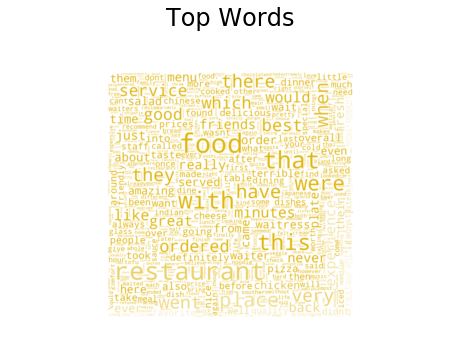

In [44]:
create_word_cloud_with_mask('yellow_square.png', big_bow, 750, "Top Words")

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

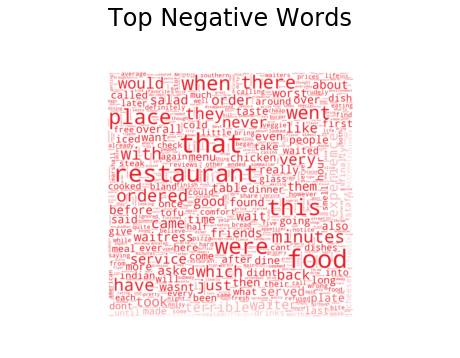

In [45]:
create_word_cloud_with_mask('red_square.png', big_bow_n, 750, "Top Negative Words")

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

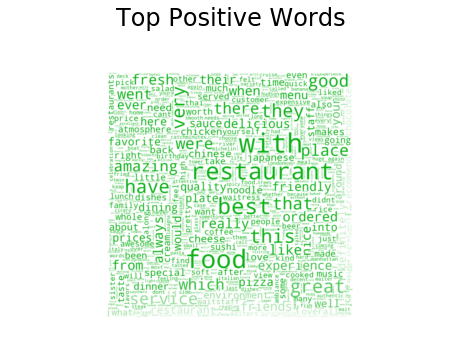

In [46]:
create_word_cloud_with_mask('green_square.png', big_bow_p, 750, "Top Positive Words")

In [47]:
most_common_neg_tup = [word for word in big_bow_n.most_common(100)]
most_common_neg_df = pd.DataFrame.from_records(most_common_neg_tup, columns=['word', 'count'])
most_common_pos_tup = [word for word in big_bow_p.most_common(100)]
most_common_pos_df = pd.DataFrame.from_records(most_common_pos_tup, columns=['word', 'count'])

In [49]:
# print(bar_plot(most_common_pos_df.sort_values(by=["count"], ascending=False)[:20], "Top 20 Items (TRUE) Prior to Cleaning"))